# Import all the necessary libraries and packages.
### There's quite a few of them.

In [2]:
import pyaudio
import wave
import IPython.display as ipd
from scipy.io import wavfile
import matplotlib
import matplotlib.pyplot as plt
from os import environ, path
from pocketsphinx.pocketsphinx import *
from sphinxbase.sphinxbase import *
import subprocess
from pydub import AudioSegment
from pydub.utils import make_chunks

import keras
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.models import load_model
from keras.models import Model
from keras import backend as K
from sklearn import metrics
from sklearn.metrics import classification_report
import librosa
import librosa.display
import numpy as np
import random
import warnings
import os
import glob
import pickle
import random
import math

from __future__ import division
import matplotlib.pyplot as plt
from scipy import interpolate

# Recording the Input Audio
### Saves the wav of the clip as a temporary file.

In [6]:
#Specify settings for the recording
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 16000
CHUNK = 1024
RECORD_SECONDS = 2
WAVE_OUTPUT_FILENAME = "./Temp/recorded.wav"
 
audio = pyaudio.PyAudio()

#Read from stream
stream = audio.open(format=FORMAT, channels=CHANNELS, rate=RATE, input=True, frames_per_buffer=CHUNK)
print "Currently recording..."
frames = []
for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)
print "Finished recording."
stream.stop_stream()
stream.close()
audio.terminate()
 
#Apply settings to the file
waveFile = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
waveFile.setnchannels(CHANNELS)
waveFile.setsampwidth(audio.get_sample_size(FORMAT))
waveFile.setframerate(RATE)
waveFile.writeframes(b''.join(frames))
waveFile.close()

Currently recording...
Finished recording.


# Hear and visualize what you just recorded.

In [7]:
fname = './Temp/recorded.wav'
ipd.Audio(fname)

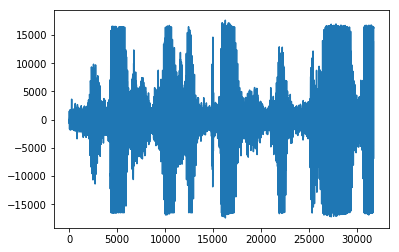

In [8]:
rate, data = wavfile.read(fname)
plt.plot(data, '-', );

# Get the phonemes using CMUsphynx
### We pass the audio in the recorded file to CMUSphynx, where the phonemes are detected. These phonemes are then mapped to viseme categories using the Jeffer's mapping. Each viseme is accompanied by its respective timestamp.

In [12]:
#need to configure the audio for cmusphynx. I think the sample rate is wrong in recording (needs to be 16k)
MODELDIR = "/home/jacob/pocketsphinx/model"
DATADIR = "./Temp"

#Create a decoder with certain model
config = Decoder.default_config()
config.set_string('-hmm', path.join(MODELDIR, 'en-us/en-us'))
config.set_string('-allphone', path.join(MODELDIR, 'en-us/en-us-phone.lm.dmp'))
config.set_float('-lw', 2.0)
config.set_float('-beam', 1e-10)
config.set_float('-pbeam', 1e-10)

#Decode streaming data.
decoder = Decoder(config)

decoder.start_utt()
stream = open(path.join(DATADIR, 'recorded.wav'), 'rb')
while True:
  buf = stream.read(1024)
  if buf:
    decoder.process_raw(buf, False, False)
  else:
    break
decoder.end_utt()

hypothesis = decoder.hyp()

phonemes = [(seg.word, seg.start_frame/100.0, seg.end_frame/100.0) for seg in decoder.seg()] #frame size is 1/100 of a second.

print(phonemes)

visemes = []
for phoneme in phonemes: #map each phoneme to it's corresponding Jeffer's viseme.
	current = [-1 , phoneme[1] , phoneme[2]] #-1 denotes an unknown phoneme.
	if phoneme[0] == 'SIL':
		current[0] = 0
	if phoneme[0] in ['F', 'V']:
		current[0] = 1
	if phoneme[0] in ['ER','OW','R','Q','W','UH','UW','AXR','UX']:
		current[0] = 2
	if phoneme[0] in ['B', 'P', 'M', 'EM']:
		current[0] = 3
	if phoneme[0] == 'AW':
		current[0] = 4
	if phoneme[0] in ['DH','TH']:
		current[0] = 5
	if phoneme[0] in ['CH', 'JH', 'SH', 'ZH']:
		current[0] = 6
	if phoneme[0] in ['OY', 'AO']:
		current[0] = 7
	if phoneme[0] in ['S', 'Z']:
		current[0] = 8
	if phoneme[0] in ['AA','AH','AY','EH','EY','IH','IY','Y','AE','AX-H','AX', 'IX', 'HH']: #HH actually doesn't belong to Jeffer's map. It's my call to put it here.
		current[0] = 9
	if phoneme[0] in ['D', 'L', 'N', 'T', 'EL', 'NX', 'EN', 'DX']:
		current[0] = 10
	if phoneme[0] in ['G', 'K', 'NG', 'ENG']:
		current[0] = 11
	visemes.append(current)

#print(visemes)

f = open('/home/jacob/Documents/Animator/Code/Temp/tempVisemes.txt','wb')
pickle.dump(visemes, f)
f.close()

[('SIL', 0.0, 0.21), ('HH', 0.22, 0.25), ('EH', 0.26, 0.33), ('IH', 0.34, 0.38), ('S', 0.39, 0.46), ('S', 0.47, 0.5), ('HH', 0.51, 0.54), ('IH', 0.55, 0.68), ('S', 0.69, 0.73), ('IH', 0.74, 0.8), ('P', 0.81, 0.9), ('EH', 0.91, 0.94), ('EH', 0.95, 1.08), ('TH', 1.09, 1.11), ('S', 1.12, 1.17), ('S', 1.18, 1.22), ('HH', 1.23, 1.28), ('AH', 1.29, 1.31), ('AO', 1.32, 1.4), ('B', 1.41, 1.43), ('DH', 1.44, 1.55), ('IY', 1.56, 1.6), ('Y', 1.61, 1.66), ('AE', 1.67, 1.72), ('AY', 1.73, 1.78), ('R', 1.79, 1.81), ('R', 1.82, 1.84), ('HH', 1.85, 1.89), ('UH', 1.9, 1.96)]


# Break the recorded audio file into chunks for the Neural Network using Pydub
### Each chunk is 2 seconds long. A bash script uses FFMPEG to then remove silences from the chunks.

In [13]:
#Break recorded audio into 2 second chunks, label filenames with ints.
myaudio = AudioSegment.from_file("/home/jacob/Documents/Animator/Code/Temp/recorded.wav" , "wav") 
chunk_length_ms = 2000 # pydub calculates in millisec
chunks = make_chunks(myaudio, chunk_length_ms) #Make chunks of two secs

#Export all of the individual chunks as wav files, add labels to csv
for i, chunk in enumerate(chunks):
    chunk_name = "/home/jacob/Documents/Animator/Code/Temp/Chunks/{0}.wav".format(i)
    chunk.export(chunk_name, format="wav")

CPU times: user 1.31 ms, sys: 244 µs, total: 1.56 ms
Wall time: 847 µs


In [14]:
#Use bash script to remove silences in input

subprocess.call(['./Scripts/rsil.sh'])

CPU times: user 0 ns, sys: 10.8 ms, total: 10.8 ms
Wall time: 349 ms


0

# Extract MFCCs from the audio using Librosa
### The chunks of audio are normalized, turned to mono, and converted into 16kHz sample rate. Then 14MFCCs are computed for frames at regular intervals for each chunk. 45 frames of non-silent audio are needed for each chunk. If less frames exist, the existing frames are concatenated to each other until length 45.

### It is essentially a dumbed down version of the MFCC extraction used for the training of the Neural Network.

In [15]:
#Extracts MFCCs from a single chunk
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name, sr=16000, mono=True, res_type='kaiser_fast')
    X = librosa.util.normalize(X)
    mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=14)
    return mfccs

#iterates over all the files within subdirectories and calls extract_feature
def parse_audio_files(Directory):
    features = []
    for fn in glob.glob(Directory):
        mfccs = extract_feature(fn)
        if mfccs.shape[1] >= 45:
            mfccs = np.resize(mfccs,(14,45))
            features.append(mfccs)
        else:
            i = 0
            mylen = len(mfccs[1])
            while mfccs.shape[1] < 45:
                mfccs = np.concatenate((mfccs, mfccs), axis=1)
            mfccs = np.resize(mfccs,(14,45))
            features.append(mfccs)  
    return np.array(features)

Directory  = '/home/jacob/Documents/Animator/Code/Temp/silChunks/*.wav'

#each element of features is the MFCCs for the chunk.
features = parse_audio_files(Directory)

#i = 0
#while i < len(features):
#    print(features[i].shape)
#    if features[i].shape != (14, 45):
#        features[i] = features[i-1]
#    i = i+1

featuresReshape = np.array([x.reshape( (14, 45, 1) ) for x in features])

print("done.")

done.
CPU times: user 21.6 ms, sys: 24.3 ms, total: 45.9 ms
Wall time: 34.9 ms


# Load the trained model of the Neural Network, and predict the classes.
### For each chunk of audio, the 45 non-silent frames are used to predict the class of the chunk. From the features array, we obtain an array of the classification probabilities of each chunk.

In [16]:
#Load the trained model
model = load_model('84_RSil_Model.h5')

#Array to hold the class probabilities for each chunk
chunkProbs = []

for elem in features:
    reshaped = np.reshape(elem, (1, 14, 45, 1))
    chunkProbs.append(model.predict(reshaped)[0])
print chunkProbs

[array([3.7840713e-04, 5.0056824e-03, 9.9461585e-01], dtype=float32)]
CPU times: user 888 ms, sys: 14.9 ms, total: 903 ms
Wall time: 975 ms


# Define a Mouth object
### The mouth has 4 attributes, which are lists containing the coordinates of the defining points according to the MPEG4 standards. xOut and yOut define the outer shape of the lips, and xIn and yIn the shape of the mouth. the single Display function uses a B-spline to connect the two sets of points.

In [17]:
class Mouth:
    
    def __init__(self, xOut, yOut, xIn, yIn):
        self.xOut = xOut
        self.yOut = yOut
        self.xIn = xIn
        self.yIn = yIn
   
    def Display(self): #B-splines interpolate
        tck,u     = interpolate.splprep( [self.xOut,self.yOut] ,s = 0 )
        xnew,ynew = interpolate.splev( np.linspace( 0, 1, 100 ), tck,der = 0)
        plt.plot(self.xOut ,self.yOut ,'o' , xnew ,ynew )
        tck,u     = interpolate.splprep( [self.xIn,self.yIn] ,s = 0 )
        xnew,ynew = interpolate.splev( np.linspace( 0, 1, 100 ), tck,der = 0)
        plt.plot(self.xIn ,self.yIn ,'o' , xnew ,ynew )
        plt.ylim(-4, 3)
        plt.xlim(-5, 5)
        plt.show()


CPU times: user 8 µs, sys: 1e+03 ns, total: 9 µs
Wall time: 13.8 µs


# Mouth Shape generation
### visemeToMouth takes a viseme and the classification probabilities as input. It then returns a mouth object. If the probability for any given class is greater than 0.8, then this is acts as a threshold, and the model mouth for the viseme class is used. 
### If not, the weightedAverage functions are used to deform the coordinates of the model mouths according to the classification probabilities.

In [18]:
def weightedAverageTwo(l1, l1Weight, l2, l2Weight):
    newList = []
    i = 0
    while (i < len(l1)):
        newCoor = ((l1[i] * l1Weight) + (l2[i] * l2Weight))/(l1Weight + l2Weight)
        newList.append(newCoor)
        i = i + 1
    return newList

def weightedAverageThree(l1, l1Weight, l2, l2Weight, l3, l3Weight):
    newList = []
    i = 0
    while (i < len(l1)):
        newCoor = ((l1[i] * l1Weight) + (l2[i] * l2Weight) + (l3[i] * l3Weight))/(l1Weight + l2Weight + l3Weight)
        newList.append(newCoor)
        i = i + 1
    return newList

def visemeToMouth(currentPhoneme, Probs):

    if currentPhoneme == 0: #'SIL' no levels
        xOut_T = xOut_W = xOut_S = [0.00,-1.05,-2.75,-4.30, -2.75, 0.00, 2.75, 4.30, 2.75, 1.05, 0.00]
        yOut_T = yOut_W = yOut_S = [1.50, 1.80, 1.22, 0.12, -1.57, -2.57, -1.57, 0.12, 1.22, 1.80, 1.50]
        xIn_T = xIn_W = xIn_S = [0.00, -1.31, -2.87, -1.32, 0.00, 1.32, 2.87, 1.31, 0.00]
        yIn_T = yIn_W = yIn_S = [0.00, 0.20, 0.23, 0.21, 0.00, 0.21, 0.23, 0.20, 0.00]

    if currentPhoneme == 1:
        xOut_T = [0.00, -1.10, -2.63, -4.12, -2.65, 0.00, 2.65, 4.12, 2.63, 1.10, 0.00]
        yOut_T = [1.34, 1.69, 1.23, 0.25, -1.30, -2.08, -1.30, 0.25, 1.23, 1.69, 1.34]
        xIn_T = [0.00, -0.93, -1.78, -0.74, 0.00, 0.74, 1.78, 0.93, 0.00]
        yIn_T = [0.64, 0.75, 0.50, 0.22, 0.00, 0.22, 0.50, 0.75, 0.64]

        xOut_W = [0.00, -1.03, -2.26, -3.87, -2.35, 0.00 , 2.35, 3.87, 2.26, 1.03, 0.00]
        yOut_W = [1.42, 1.68, 1.29, 0.12, -1.73, -2.36, -1.73, 0.12, 1.29, 1.68, 1.42]
        xIn_W = [0.00, -0.74, -2.22, -0.74, 0.00, 0.74, 2.22, 0.74, 0.00]
        yIn_W = [0.36, 0.38, 0.23, 0.12, 0.00, 0.12, 0.23, 0.38, 0.36]

        xOut_S = [0.00, -0.79, -2.08, -3.39, -2.01, 0.00, 2.01, 3.39, 2.08, 0.79, 0.00]
        yOut_S = [1.33, 1.49, 1.16, -0.01, -1.75, -2.60, -1.75, -0.01, 1.16, 1.49, 1.33]
        xIn_S = [0.00, -0.89, -1.51, -0.87, 0.00, 0.87, 1.51, 0.89, 0.00]
        yIn_S = [0.69, 0.60, 0.18, -0.19, -0.48, -0.19, 0.18, 0.60, 0.69]

    if currentPhoneme == 2:
        xOut_T = [0.00, -1.14, -2.78, -4.18, -2.94, 0.00, 2.94, 4.18, 2.78, 1.14, 0.00]
        yOut_T = [1.69, 2.11, 1.36, -0.12, -2.23, -3.25, -2.23, -0.12, 1.36, 2.11, 1.69]
        xIn_T = [0.00, -1.21, -2.85, -1.35, 0.00, 1.35, 2.85, 1.21, 0.00]
        yIn_T = [0.27, 0.33, -0.11, -0.47, -0.76, -0.47 ,-0.11, 0.33, 0.27]

        xOut_W = [0.00, -1.00, -2.37, -3.65, -2.78, 0.00, 2.78, 3.65, 2.37, 1.00, 0.00]
        yOut_W = [1.81, 2.19, 1.57, 0.15, -1.49, -2.59, -1.49, 0.15, 1.57, 2.19, 1.81]
        xIn_W = [0.00, -1.09, -2.38, -1.07, 0.00, 1.07, 2.38, 1.09, 0.00]
        yIn_W = [0.47, 0.54, 0.30, -0.04, -0.33, -0.04, 0.30, 0.54, 0.47]

        xOut_S = [0.00, -0.85, -2.46, -3.07, -2.61, 0.00, 2.61, 3.07, 2.46, 0.85, 0.00]
        yOut_S = [2.82, 2.96, 2.11, 0.41, -1.63, -3.68, -1.63, 0.41, 2.11, 2.96, 2.82]
        xIn_S = [0.00, -1.50, -2.52, -1.51, 0.00, 1.51, 2.52, 1.50, 0.00]
        yIn_S = [1.42, 1.37, 0.18, -0.85, -1.44, -0.85, 0.18, 1.37, 1.42]

    if currentPhoneme == 3:
        xOut_T = [0.00, -0.60, -2.17, -3.90, -2.81, 0.00, 2.81, 3.90, 2.17, 0.60, 0.00] 
        yOut_T = [0.99, 1.28, 0.97, 0.44, -1.01, -1.98, -1.01, 0.44, 0.97, 1.28, 0.99]
        xIn_T = [0.00, -1.26, -2.83, -1.9, 0.00, 1.9, 2.83, 1.26, 0.00]
        yIn_T = [-0.11, 0.06, 0.25, -0.06, -0.25, -0.06, 0.25, 0.06, -0.11]

        xOut_W = [0.00, -0.76, -2.00, -3.36, -2.13, 0.00, 2.13, 3.36, 2.00, 0.76, 0.00]
        yOut_W = [0.95, 1.38, 1.13, 0.35, -1.25, -2.00, -1.25, 0.35, 1.13, 1.38, 0.95]
        xIn_W = [0.00, -1.10, -2.33, -1.10, 0.00, 1.10, 2.33, 1.10, 0.00]
        yIn_W = [-0.31, 0.00, 0.38, 0.00, -0.31, 0.00, 0.38, 0.00, -0.31]

        xOut_S = [0.00, -0.83, -2.38, -3.31, -2.09, 0.00, 2.09, 3.31, 2.38, 0.83,0.00]
        yOut_S = [0.84, 1.04, 0.88, 0.35, -0.59, -0.85, -0.59, 0.35, 0.88, 1.04, 0.84]
        xIn_S = [0.00, -1.22, -3.05, -1.23, 0.00, 1.23, 3.05, 1.22, 0.00]
        yIn_S = [0.00, 0.30, 0.47, 0.21, 0.00, 0.21, 0.47, 0.30, 0.00]

    if currentPhoneme == 4:
        xOut_T = [0.00, -1.00, -2.49, -3.73, -2.69, 0.00, 2.69,3.73, 2.49, 1.00, 0.00] 
        yOut_T = [1.90, 2.37, 1.84, 0.26, -2.02, -3.17, -2.02, 0.26, 1.84, 2.37, 1.90]
        xIn_T = [0.00, -1.17, -2.38, -1.31, 0.00, 1.31, 2.38, 1.17, 0.00]
        yIn_T = [0.49, 0.60, 0.29, -0.28, -0.58, -0.28, 0.29, 0.60, 0.49]

        xOut_W = [0.00, -0.74, -2.10, -3.14, -2.40, 0.00, 2.40, 3.14, 2.10, 0.74, 0.00]
        yOut_W = [1.53, 1.92, 1.40, 0.11, -1.84, -3.10, -1.84, 0.11, 1.40, 1.92, 1.53]
        xIn_W = [0.00, -0.83, -1.63, -0.87, 0.00, 0.87, 1.63, 0.83, 0.00]
        yIn_W = [0.19, 0.19, 0.16, -0.27, -0.48, -0.27, 0.16, 0.19, 0.19]

        xOut_S = [0.00, -0.74, -2.08, -3.38, -2.50, 0.00, 2.50, 3.38, 2.08, 0.74, 0.00]
        yOut_S = [1.96, 2.18, 1.89, 0.29, -1.90, -3.07, -1.90, 0.29, 1.89, 2.18, 1.96]
        xIn_S = [0.00, -1.17, -2.10, -1.22, 0.00, 1.22, 2.10, 1.17, 0.00]
        yIn_S = [0.50, 0.68, 0.18, -0.41, -0.7, -0.41, 0.18, 0.68, 0.50]

    if currentPhoneme == 5:
        xOut_T = [0.00, -0.67, -2.58, -3.84, -2.69, 0.00, 2.69, 3.84, 2.58, 0.67, 0.00] 
        yOut_T = [2.40, 2.81, 1.92, 0.09, -2.02, -3.23, -2.02, 0.09, 1.92, 2.81, 2.40]
        xIn_T = [0.00, -2.03, -2.9, -1.45, 0.00, 1.45, 2.9, 2.03, 0.00]
        yIn_T = [0.90, 0.78, 0.10, -0.47, -0.58, -0.47, 0.10, 0.78, 0.90]

        xOut_W = [0.00, -0.89, -2.14, -3.25, -2.31, 0.00, 2.31, 3.25, 2.14, 0.89, 0.00]
        yOut_W = [1.82, 2.20, 1.69, 0.24, -1.78, -2.7, -1.78, 0.24, 1.69, 2.20, 1.82]
        xIn_W = [0.00, -0.73, -1.36, -0.73, 0.00, 0.73, 1.36, 0.73, 0.00]
        yIn_W = [0.48, 0.52, 0.44, 0.00, -0.20, 0.01, 0.44, 0.52, 0.48]

        xOut_S = [0.00,-1.12, -2.43, -3.63, -2.85, 0.00, 2.85, 3.63, 2.43, 1.12, 0.00]
        yOut_S = [2.33, 2.67, 2.09, 0.34, -2.28, -3.51, -2.28, 0.34, 2.09, 2.67, 2.33]
        xIn_S = [0.00,-1.13, -2.10, -1.25, 0.00, 1.25, 2.10, 1.13, 0.00]
        yIn_S = [0.95, 0.90, 0.16, -0.90, -1.03, -0.90, 0.16, 0.90, 0.95]

    if currentPhoneme == 6:
        xOut_T = [0.00, -1.02, -2.58, -3.80, -2.63, 0.00, 2.63, 3.80, 2.58, 1.02, 0.00] 
        yOut_T = [2.27, 2.57, 1.92, -0.01, -2.14, -3.35, -2.14, -0.01, 1.92, 2.57, 2.27]
        xIn_T = [0.00, -1.30, -1.98, -1.16, 0.00, 1.16, 1.98, 1.30, 0.00]
        yIn_T = [0.57, 0.53, 0.10, -0.48, -0.6, -0.48, 0.10, 0.53, 0.57]

        xOut_W = [0.00, -1.05, -2.33, -3.26, -2.40, 0.00, 2.40, 3.26, 2.33, 1.05, 0.00]
        yOut_W = [1.64, 1.98, 1.45, 0.20, -2.00, -2.95, -2.00, 0.20, 1.45, 1.98, 1.64]
        xIn_W = [0.00, -0.95, -1.86, -1.08, 0.00, 1.08, 1.86, 0.95, 0.00]
        yIn_W = [0.48, 0.48, 0.23, -0.33, -0.52,-0.33, 0.23, 0.48, 0.48]

        xOut_S = [0.00, -1.59, -2.97, -3.21, -2.78, 0.00, 2.78, 3.21, 2.97, 1.59, 0.00]
        yOut_S = [3.2, 3.51, 2.72, 0.26, -2.41, -3.86, -2.41, 0.26, 2.72, 3.51, 3.20]
        xIn_S = [0.00, -1.10, -2.07, -1.15, 0.00, 1.15, 2.07, 1.10, 0.00]
        yIn_S = [1.72, 1.62, 0.24, -0.83, -1.46, -0.83,0.24, 1.62, 1.72]

    if currentPhoneme == 7:
        xOut_T = [0.00, -0.96, -2.25, -3.52, -2.48, 0.00, 2.48, 3.52, 2.25, 0.96, 0.00] 
        yOut_T = [2.08, 2.30, 1.62, 0.15, -1.95, -3.09, -1.95, 0.15, 1.62, 2.30, 2.08]
        xIn_T = [0.00, -1.26, -1.84, -1.22, 0.00, 1.22, 1.84, 1.26, 0.00]
        yIn_T = [0.38, 0.37, 0.15, -0.15, -0.42, -0.15, 0.15, 0.37, 0.38]

        xOut_W = [0.00, -1.01, -2.39, -3.63, -2.66, 0.00, 2.66, 3.63, 2.39, 1.01, 0.00]
        yOut_W = [1.73, 2.08, 1.56, 0.17, -1.74, -2.79, -1.74, 0.17, 1.56, 2.08, 1.73]
        xIn_W = [0.00, -1.19, -2.55, -1.16, 0.00, 1.16, 2.55, 1.19, 0.00]
        yIn_W = [0.48, 0.56, 0.23, -0.25, -0.44, -0.25, 0.23, 0.56, 0.48]

        xOut_S = [0.00, -0.99, -2.88, -3.83, -2.82, 0.00, 2.82, 3.83, 2.88, 0.99, 0.00]
        yOut_S = [2.70, 2.90, 1.96, 0.13, -2.06, -3.86, -2.06, 0.13, 1.96, 2.90, 2.70]
        xIn_S = [0.00, -1.94, -3.49, -1.91, 0.00, 1.91, 3.49, 1.94, 0.00]
        yIn_S = [1.30, 1.09, 0.12, -0.91, -1.55, -0.91, 0.12, 1.09, 1.30]

    if currentPhoneme == 8:
        xOut_T = [0.00, -0.83, -2.10, -3.39, -2.43, 0.00, 2.43, 3.39, 2.10, 0.83, 0.00] 
        yOut_T = [1.84, 2.17, 1.55, -0.20, -2.17, -3.13, -2.17, -0.20, 1.55, 2.17, 1.84]
        xIn_T = [0.00, -1.27, -2.09, -1.28, 0.00, 1.28, 2.09, 1.27, 0.00]
        yIn_T = [0.34, 0.39, -0.06, -0.53, -0.73, -0.53, -0.06, 0.39, 0.34]

        xOut_W = [0.00, -0.88, -2.46, -3.41, -2.22, 0.00, 2.22, 3.41, 2.46, 0.88, 0.00]
        yOut_W = [1.73, 1.98, 1.31, 0.00, -1.65, -2.45, -1.65, 0.00, 1.31, 1.98, 1.73]
        xIn_W = [0.00, -0.93, -1.80, -0.93, 0.00, 0.93, 1.80, 0.93, 0.00]
        yIn_W = [0.34, 0.32, 0.17, -0.03, -0.24, -0.03, 0.17, 0.32, 0.34]

        xOut_S = [0.00, -1.08, -2.88, -4.04, -2.86, 0.00, 2.86, 4.04, 2.88, 1.08, 0.00]
        yOut_S = [2.70, 2.92, 1.96, 0.21, -2.14, -3.38, -2.14, 0.21, 1.96, 2.92, 2.70]
        xIn_S = [0.00, -1.94, -3.83, -1.91, 0.00, 1.91, 3.83, 1.94, 0.00]
        yIn_S = [1.30, 1.09, 0.20, -0.91, -1.22, -0.91, 0.20, 1.09, 1.30]

    if currentPhoneme == 9:
        xOut_T = [0.00, -0.83, -2.12, -3.44, -2.34, -0.00, 2.34, 3.44, 2.12, 0.83, 0.00] 
        yOut_T = [2.25, 2.44, 1.70, 0.19, -1.98, -2.96, -1.98, 0.19, 1.70, 2.44, 2.25]
        xIn_T = [0.00, -1.48, -2.99, -1.67, 0.00, 1.67, 2.99, 1.48, 0.00]
        yIn_T = [0.71, 0.83, 0.04, -0.36, -0.69, -0.36, 0.04, 0.83, 0.71]

        xOut_W = [0.00, -0.88, -2.23, -3.47, -2.37, 0.00, 2.37, 3.47, 2.23, 0.88, 0.00]
        yOut_W = [1.73, 1.98, 1.31, 0.07, -2.02, -2.91, -2.02, 0.07, 1.31, 1.98, 1.73]
        xIn_W = [0.00, -1.33, -2.66, -1.37, 0.00, 1.37, 2.66, 1.33, 0.00]
        yIn_W = [0.42, 0.47, 0.20, -0.27, -0.52, -0.27, 0.20, 0.47, 0.42]  

        xOut_S = [0.00, -0.97, -2.90, -3.49, -2.71, 0.00, 2.71, 3.49, 2.90, 0.97, 0.00]
        yOut_S = [2.84, 2.92, 2.06, 0.26, -2.04, -4.11, -2.04, 0.26, 2.06, 2.92, 2.84]
        xIn_S = [0.00, -2.02, -3.39, -2.11, 0.00, 2.11, 3.39, 2.02, 0.00]
        yIn_S = [1.68, 1.34, 0.26, -1.25, -2.18, -1.25, 0.26, 1.34, 1.68]

    if currentPhoneme == 10:
        xOut_T = [0.00, -0.83, -2.09, -3.67, -2.57, 0.00, 2.57, 3.67, 2.09, 0.83, 0.00] 
        yOut_T = [2.03, 2.26, 1.60, 0.00, -2.07, -3.17, -2.07, 0.00, 1.60, 2.26, 2.03]
        xIn_T = [0.00, -1.48, -2.37, -1.42, 0.00, 1.42, 2.37, 1.48, 0.00]
        yIn_T = [0.49, 0.5, 0.14, -0.33, -0.58, -0.33, 0.14, 0.5, 0.49]

        xOut_W = [0.00, -1.10, -2.42, -3.49, -2.37, 0.00, 2.37, 3.49, 2.42, 1.10, 0.00]
        yOut_W = [1.40, 1.68, 1.10, -0.03, -2.02, -2.88, -2.02, -0.03, 1.10, 1.68, 1.40]
        xIn_W = [0.00, -1.33, -2.46, -1.35, 0.00, 1.35, 2.46, 1.33, 0.00]
        yIn_W = [0.00, 0.19, 0.11, -0.19, -0.43, -0.19, 0.11, 0.19, 0.00]

        xOut_S = [0.00, -0.92, -2.85, -4.38, -3.39, 0.00, 3.39, 4.38, 2.85, 0.92, 0.00]
        yOut_S = [1.76, 1.89, 1.61, 0.20, -1.98, -3.58, -1.98, 0.20, 1.61, 1.89, 1.76]
        xIn_S = [0.00, -1.72, -4.04, -1.68, 0.00, 1.68, 4.04, 1.72, 0.00]
        yIn_S = [0.59, 0.84, 0.17, -1.42, -1.58, -1.42, 0.17, 0.84, 0.59]

    if currentPhoneme == 11:
        xOut_T = [0.00, -0.83, -2.20, -3.49, -2.52, 0.00, 2.52, 3.49, 2.20, 0.83, 0.00] 
        yOut_T = [2.09, 2.26, 1.70, 0.19, -1.94, -3.12, -1.94, 0.19, 1.70, 2.26, 2.09]
        xIn_T = [0.00, -1.51, -2.90, -1.45, 0.00, 1.45, 2.90, 1.51, 0.00]
        yIn_T = [0.69, 0.61, 0.05, -0.48, -0.76, -0.48, 0.05, 0.61, 0.69]

        xOut_W = [0.00, -0.93, -2.33, -3.45, -2.63, 0.00, 2.63, 3.45, 2.33, 0.93, 0.00]
        yOut_W = [1.50, 1.86, 1.33, 0.23, -1.57, -2.87, -1.57, 0.23, 1.33, 1.86, 1.50]
        xIn_W = [0.00, -1.27, -2.53, -1.35, 0.00, 1.35, 2.53, 1.27, 0.00]
        yIn_W = [0.38, 0.47, 0.31, -0.19, -0.47, -0.19, 0.31, 0.47, 0.38]

        xOut_S = [0.00, -1.17, -2.85, -3.91, -2.97, 0.00, 2.97, 3.91, 2.85, 1.17, 0.00]
        yOut_S = [2.19, 2.51, 1.70, 0.21, -1.74, -4.15, -1.74, 0.21, 1.70, 2.51, 2.19]
        xIn_S = [0.00, -1.52, -3.45, -1.71, 0.00, 1.71, 3.25, 1.52, 0.00]
        yIn_S = [1.05, 0.98, 0.19, -0.98, -1.82, -0.98, 0.19, 0.98, 1.05]
        
    maxProb = max(Probs)
    maxIndex = Probs.index(maxProb)
    
    if maxProb >= 0.8: #if
        if maxIndex == 0: #whisper
            xOut = xOut_W
            yOut = yOut_W
            xIn = xIn_W
            yIn = yIn_W
        if maxIndex == 1: #talk
            xOut = xOut_T
            yOut = yOut_T
            xIn = xIn_T
            yIn = yIn_T
        if maxIndex == 2: #shout
            xOut = xOut_S
            yOut = yOut_S
            xIn = xIn_S
            yIn = yIn_S
    else:
        if maxIndex == 0:
            xOut = weightedAverageTwo(xOut_W, Probs[0], xOut_T, Probs[1])
            yOut = weightedAverageTwo(yOut_W, Probs[0], yOut_T, Probs[1])
            xIn = weightedAverageTwo(xIn_W, Probs[0], xIn_T, Probs[1])
            yIn = weightedAverageTwo(yIn_W, Probs[0], yIn_T, Probs[1])
        if maxIndex == 1:
            xOut = weightedAverageThree(xOut_W, Probs[0], xOut_T, Probs[1], xOut_S, Probs[2])
            yOut = weightedAverageThree(yOut_W, Probs[0], yOut_T, Probs[1], yOut_S, Probs[2])
            xIn = weightedAverageThree(xIn_W, Probs[0], xIn_T, Probs[1], xIn_S, Probs[2])
            yIn = weightedAverageThree(yIn_W, Probs[0], yIn_T, Probs[1], yIn_S, Probs[2])
        if maxIndex == 2:
            xOut = weightedAverageTwo(xOut_T, Probs[1], xOut_S, Probs[2])
            yOut = weightedAverageTwo(yOut_T, Probs[1], yOut_S, Probs[2])
            xIn = weightedAverageTwo(xIn_T, Probs[1], xIn_S, Probs[2])
            yIn = weightedAverageTwo(yIn_T, Probs[1], yIn_S, Probs[2])
    mouthGen = Mouth(xOut, yOut, xIn, yIn)
    return mouthGen


CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 12.2 µs
Parser   : 110 ms


# Piece it all together
### for each viseme, the getChunk function calculates the chunk according to the timestamps. We have the classification probabilities for each chunk, and generate a mouth using these. We iterate for each viseme, so we return a list Mouth objects and their timestamps.

[(<__main__.Mouth instance at 0x7f3d575ba248>, 0.0, 0.21), (<__main__.Mouth instance at 0x7f3d4c146290>, 0.22, 0.25), (<__main__.Mouth instance at 0x7f3d3868f248>, 0.26, 0.33), (<__main__.Mouth instance at 0x7f3d57668050>, 0.34, 0.38), (<__main__.Mouth instance at 0x7f3d57668128>, 0.39, 0.46), (<__main__.Mouth instance at 0x7f3d576680e0>, 0.47, 0.5), (<__main__.Mouth instance at 0x7f3d5769ecb0>, 0.51, 0.54), (<__main__.Mouth instance at 0x7f3d5762b950>, 0.55, 0.68), (<__main__.Mouth instance at 0x7f3d3864f4d0>, 0.69, 0.73), (<__main__.Mouth instance at 0x7f3d3864f320>, 0.74, 0.8), (<__main__.Mouth instance at 0x7f3d3864f0e0>, 0.81, 0.9), (<__main__.Mouth instance at 0x7f3d3864f290>, 0.91, 0.94), (<__main__.Mouth instance at 0x7f3d3864f488>, 0.95, 1.08), (<__main__.Mouth instance at 0x7f3d3864f368>, 1.09, 1.11), (<__main__.Mouth instance at 0x7f3d3864f3b0>, 1.12, 1.17), (<__main__.Mouth instance at 0x7f3d3864f758>, 1.18, 1.22), (<__main__.Mouth instance at 0x7f3d3862eb00>, 1.23, 1.28), 

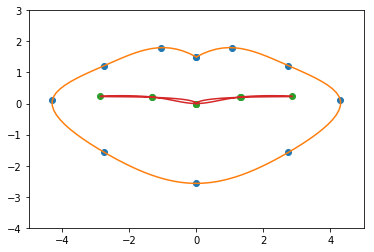

0.22


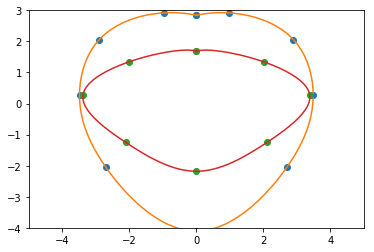

0.26


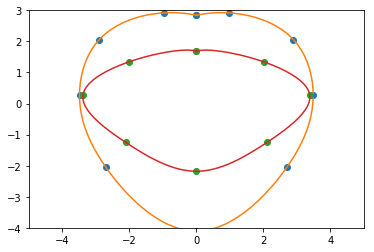

0.34


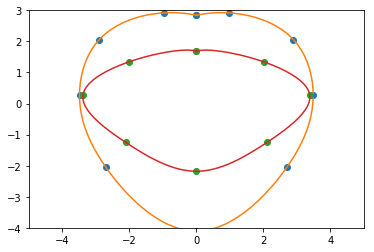

0.39


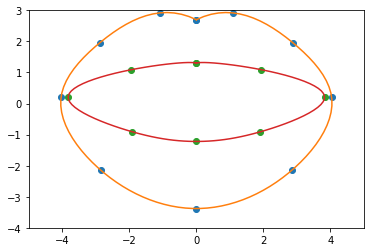

0.47


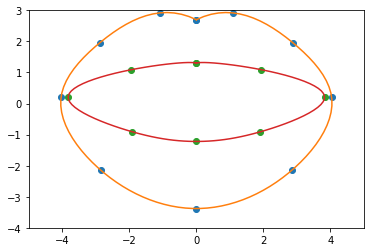

0.51


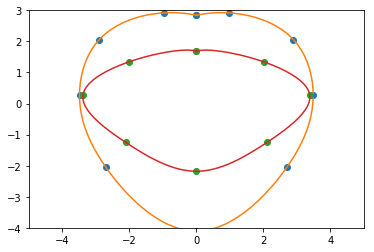

0.55


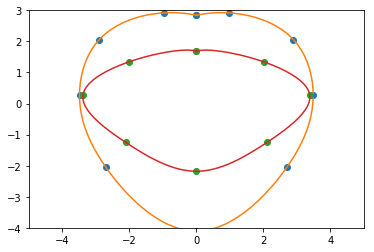

0.69


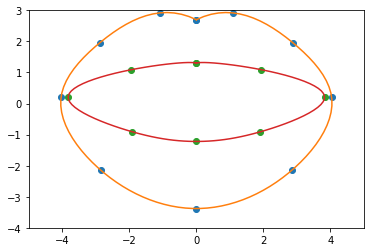

0.74


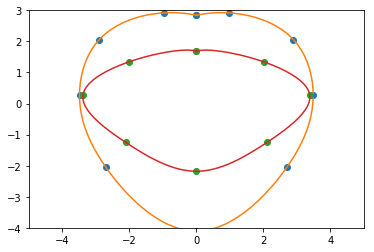

0.81


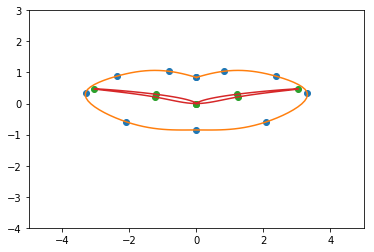

0.91


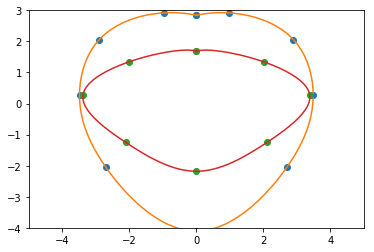

0.95


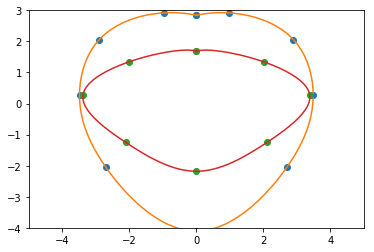

1.09


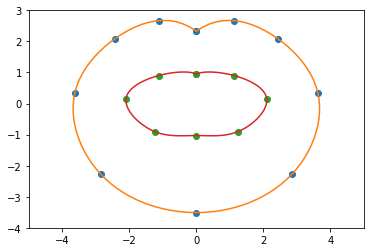

1.12


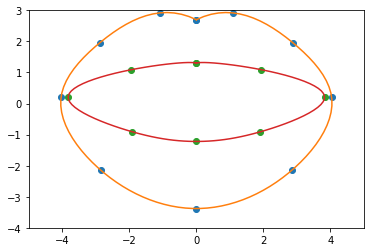

1.18


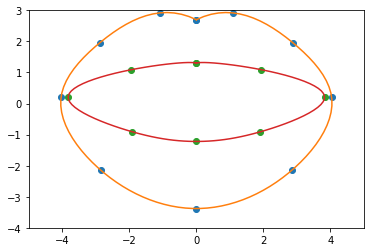

1.23


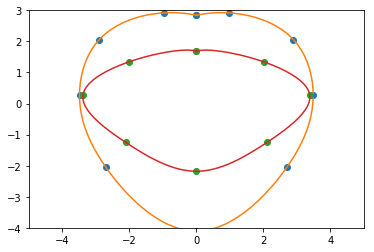

1.29


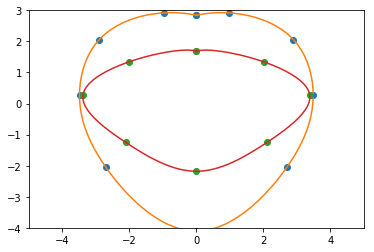

1.32


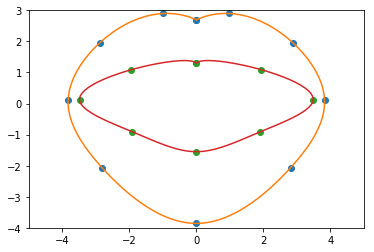

1.41


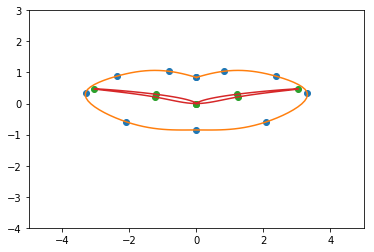

1.44


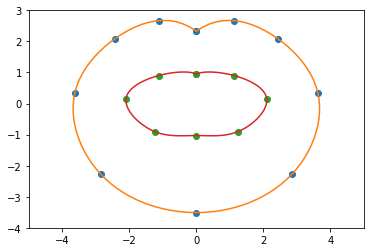

1.56


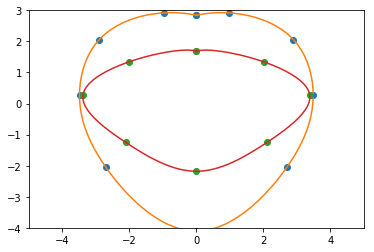

1.61


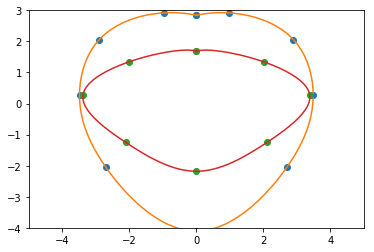

1.67


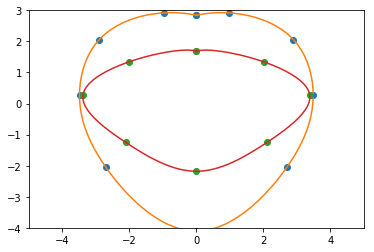

1.73


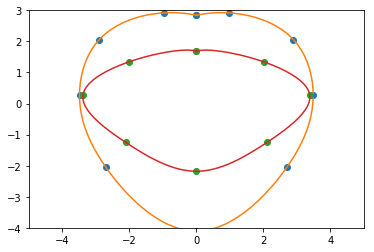

1.79


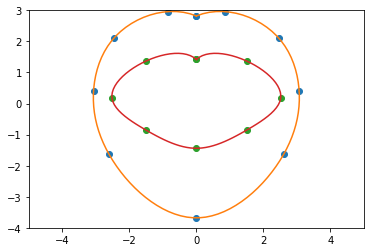

1.82


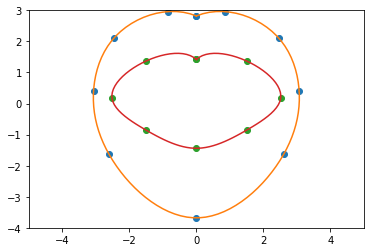

1.85


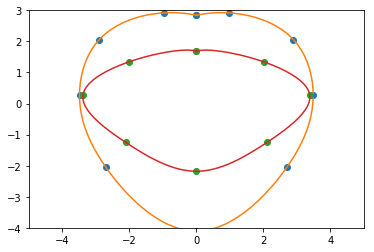

1.9


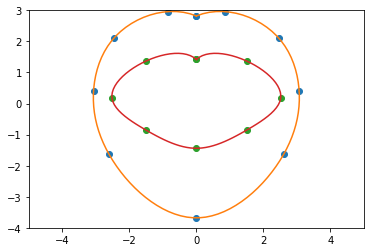

CPU times: user 8.87 s, sys: 8.8 s, total: 17.7 s
Wall time: 6.67 s


In [25]:
%%time
#jumble stuff together
#we have visemes = [[0, 0.0, 0.14],...] and 
#chunkProbs = [array([2.720129e-01, 7.274164e-01, 5.707991e-04]

#for element in visemes
    #calculate chunk # according to timestamps
    #Generate mouthShape from chunkProbs
    #Return an array of mouthShape objects? (4 arrays, start, stop)
    

def getChunk(start, stop):
    stopChunk = int(stop) / 2
    startChunk = int(start) / 2
    if stopChunk == startChunk:
        return stopChunk
    else:
        if (2 - (start % 2.0)) > (stop % 2.0):
            return startChunk
        else:
            return stopChunk
    
final = []

for viseme in visemes:
    chunkNumber = getChunk(viseme[1], viseme[2])
    mouthShape = visemeToMouth(viseme[0], chunkProbs[0].tolist())
    elem = (mouthShape, viseme[1], viseme[2])
    final.append(elem)
    
print(final)
for i in final:
    print(i[1])
    i[0].Display()